과제 내용 : 기계 독해 (LSTM 기반 영영화 긍/부정 결과 데이터셋 결과 기반 예측.)


#Mission! : 

vocab tockenizer, batch 크기 등과 

LSTM 모델의 하이퍼파라미터를 튜닝해서 최대한 

Accuracy를 올려보세요!

### Import 라이브러리 & Version 이슈

In [1]:
!pip install torch==1.8.0 torchtext==0.9.0

# pip install 후에 런타임을 다시 시작해야 반영됨! 이걸 몰라서 한참을 헤맴...

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.8.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.8.0 which is incompatible.


In [2]:
# PyTorch 버전 확인

import torch

print(torch.__version__)

1.8.0


In [3]:
# Python 버전 확인

import sys

print(sys.version)

3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]


In [4]:
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

cuda version: 10.2
cudnn version:7605


In [5]:
import os
import numpy as np
import pandas as pd
import random

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import urllib.request
DEVICE = torch.device("cpu")

import torch.nn.functional as F
from torchtext.legacy import data

In [6]:
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print("device_count: {}".format(device_count))
    for device_num in range(device_count):
      print("device {} capability {}".format(
          device_num,
          torch.cuda.get_device_capability(device_num)))
      print("device {} name {}".format(
          device_num, torch.cuda.get_device_name(device_num)))
else:
    print("no cuda device")

device_count: 1
device 0 capability (7, 5)
device 0 name Tesla T4


In [7]:
from torchtext.legacy.data import TabularDataset

### 데이터 다운로드: 깃헙

* 대표적인 영어 데이터인 IMDb 리뷰 데이터

In [8]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x7f8c6ad9ed90>)

In [9]:
df = pd.read_csv('IMDb_Reviews.csv', encoding='utf-8')
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


첫 열은 영화 리뷰로, 둘째 열은 긍정/부정을 나타내는 열입니다. (긍정 1 부정 0)

### 데이터셋 만들기
여러분의 커스텀 데이터셋을 만들어보세요. 아래 있는 코드를 쓰셔도 좋고 개별 구글링 진행하셔도 좋습니다.

https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00

In [10]:
print('전체 샘플의 개수 : {}'.format(len(df)))

전체 샘플의 개수 : 50000


샘플 개수 50000개, train : validation : test = 6:2:2로 나누겠습니다

In [11]:
train_datapipe = df[:30000]
val_datapipe = df[30000:40000]
test_datapipe = df[40000:]

In [12]:
train_datapipe.to_csv("train_data.csv", index=False)
val_datapipe.to_csv("val_data.csv", index=False)
test_datapipe.to_csv("test_data.csv", index=False)

Initialise the CustomTextDataset class


In [13]:
# define data and class labels

text = train_datapipe.review
labels = train_datapipe.sentiment

In [14]:
# 필드 정의
# 데이터 전처리를 어떻게 진행할 것인가를 정의

TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=str.split,
                  lower=True,
                  batch_first=True,
                  fix_length=20)

LABEL = data.Field(sequential=False,
                   use_vocab=False,
                   batch_first=False,
                   is_target=True)

In [15]:
# 필드 정의 cell에서 지정한 토큰화 방법대로 토큰화 진행

train_data, val_data, test_data = TabularDataset.splits(
        path='.', train='train_data.csv', validation='val_data.csv', test='test_data.csv', format='csv',
        fields=[('text', TEXT), ('label', LABEL)], skip_header=True)

In [18]:
print('train 샘플의 개수 : {}'.format(len(train_data)))
print('validation 샘플의 개수 : {}'.format(len(val_data)))
print('test 샘플의 개수 : {}'.format(len(test_data)))

train 샘플의 개수 : 30000
validation 샘플의 개수 : 10000
test 샘플의 개수 : 10000


In [19]:
# test sample의 첫 번째 샘플을 확인해보자

print(vars(train_data[0]))

{'text': ['my', 'family', 'and', 'i', 'normally', 'do', 'not', 'watch', 'local', 'movies', 'for', 'the', 'simple', 'reason', 'that', 'they', 'are', 'poorly', 'made,', 'they', 'lack', 'the', 'depth,', 'and', 'just', 'not', 'worth', 'our', 'time.<br', '/><br', '/>the', 'trailer', 'of', '"nasaan', 'ka', 'man"', 'caught', 'my', 'attention,', 'my', 'daughter', 'in', "law's", 'and', "daughter's", 'so', 'we', 'took', 'time', 'out', 'to', 'watch', 'it', 'this', 'afternoon.', 'the', 'movie', 'exceeded', 'our', 'expectations.', 'the', 'cinematography', 'was', 'very', 'good,', 'the', 'story', 'beautiful', 'and', 'the', 'acting', 'awesome.', 'jericho', 'rosales', 'was', 'really', 'very', 'good,', "so's", 'claudine', 'barretto.', 'the', 'fact', 'that', 'i', 'despised', 'diether', 'ocampo', 'proves', 'he', 'was', 'effective', 'at', 'his', 'role.', 'i', 'have', 'never', 'been', 'this', 'touched,', 'moved', 'and', 'affected', 'by', 'a', 'local', 'movie', 'before.', 'imagine', 'a', 'cynic', 'like', 'me

In [20]:
# 필드 구성 확인

print(train_data.fields.items())

dict_items([('text', <torchtext.legacy.data.field.Field object at 0x7f8c0bb38a30>), ('label', <torchtext.legacy.data.field.Field object at 0x7f8c0bb389d0>)])


### 단어 집합(Vocabulary) 만들기

위와 같이 토큰화 전처리가 끝나면 각 단어에 고유한 정수를 매핑하는 intger encoding 작업이 필요한데, 이를 위해서는 단어 집합(vocabulary)을 만들어야 함

In [21]:
TEXT.build_vocab(train_data, min_freq=10)

In [22]:
vocab_size = len(TEXT.vocab)
n_classes = 2

In [23]:
print('단어 집합의 크기 : {}'.format(len(TEXT.vocab)))
print('클래스의 개수 : {}'.format(n_classes))

단어 집합의 크기 : 30547
클래스의 개수 : 2


In [24]:
# 생성된 단어 집합 내의 단어들 확인

print(TEXT.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f8bd4ac7f40>>, {'<unk>': 0, '<pad>': 1, 'the': 2, 'a': 3, 'and': 4, 'of': 5, 'to': 6, 'is': 7, 'in': 8, 'i': 9, 'this': 10, 'it': 11, 'that': 12, '/><br': 13, 'was': 14, 'as': 15, 'with': 16, 'for': 17, 'but': 18, 'on': 19, 'movie': 20, 'his': 21, 'are': 22, 'not': 23, 'you': 24, 'film': 25, 'have': 26, 'he': 27, 'be': 28, 'at': 29, 'one': 30, 'by': 31, 'an': 32, 'they': 33, 'from': 34, 'who': 35, 'all': 36, 'like': 37, 'so': 38, 'just': 39, 'or': 40, 'has': 41, 'about': 42, "it's": 43, 'her': 44, 'if': 45, 'some': 46, 'out': 47, 'what': 48, 'very': 49, 'when': 50, 'more': 51, 'there': 52, 'would': 53, 'even': 54, 'my': 55, 'good': 56, 'she': 57, 'their': 58, 'only': 59, 'no': 60, 'really': 61, 'had': 62, 'up': 63, 'can': 64, 'which': 65, 'see': 66, 'were': 67, 'than': 68, '-': 69, 'we': 70, 'been': 71, 'into': 72, 'get': 73, 'will': 74, 'much': 75, 'because': 76, 'story': 77, 'how': 78, 'most': 7

### torchtext의 dataloader 만들기

> dataloader: 미니 배치만큼 데이터를 로드하게 만들어주는 역할

In [25]:
from torchtext.legacy.data import Iterator

In [26]:
batch_size = 5 # 배치 크기를 임의로 아주 작게 설정해보자

In [29]:
train_loader = Iterator(dataset=train_data, batch_size = batch_size)
val_loader = Iterator(dataset=val_data, batch_size = batch_size)
test_loader = Iterator(dataset=test_data, batch_size = batch_size)

In [31]:
print('train 데이터의 미니 배치 수 : {}'.format(len(train_loader)))
print('validation 데이터의 미니 배치 수 : {}'.format(len(val_loader)))
print('test 데이터의 미니 배치 수 : {}'.format(len(test_loader)))

# 30000개의 train data의 샘플을 배치 크기 5씩 묶어주었기 때문에 6000개의 미니 배치
# 각 10000개의 validation data, test data의 샘플을 배치 크기 5씩 묶어주었기 때문에 2000개의 미니 배치

train 데이터의 미니 배치 수 : 6000
validation 데이터의 미니 배치 수 : 2000
test 데이터의 미니 배치 수 : 2000


In [32]:
batch = next(iter(train_loader)) # 첫 번째 미니 배치

In [33]:
print(type(batch)) # 첫 번째 미니 배치에 대한 자료형

<class 'torchtext.legacy.data.batch.Batch'>


In [34]:
print(batch.text) # 첫 번째 미니 배치의 text 필드 호출

tensor([[    9,   259,    10,    20,    29,     3,  5620,  4763,  3385,     4,
           148,  1142,     9,   145,   948,    17,   112,    10,    20,     7],
        [    9,   259,     0,     0,    30,   389,     4,   195,    11,    14,
             0,    18,  1122,  2374,   288,  5417,  3561,  3195,  1778,  3510],
        [  148,     3,   551,   356,     5,     2, 12599,     5, 18374,   277,
           846,     4,     9,    61,   462,    10,  1845,     9,   462,   609],
        [  144,   117,     9,   140,     6,    66,    10,  2928,  3938,    76,
          1398,  5236,    14,     8,    11,     4,     8,     2,   595,    27],
        [   10,   118,   184,   284,    46,     5,     2,   705,    31,     2,
           715,     3,  1512,  2896,  1299,     7,    30,     5,   135,  5011]])


# DataLoader
(dataset, batch_size=1, shuffle=False, sampler=None,  batch_sampler=None, num_workers=0, collate_fn=None,
pin_memory=False, drop_last=False, timeout=0,
worker_init_fn=None)

In [35]:
# create custom dataset class

class CustomTextDataset(Dataset):
    def __init__(self, text, labels):
        self.labels = labels
        self.text = text

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.text[idx]
        sample = (label, data)
        return sample

# define data and class labels
text = text
labels = labels

# create Pandas DataFrame
text_labels_df = pd.DataFrame({'Text': text, 'Labels': labels})

# define data set object
TD = CustomTextDataset(text_labels_df['Text'], text_labels_df['Labels'])

# Display image and label.
print('\nFirst iteration of data set: ', next(iter(TD)), '\n')

# Print how many items are in the data set
print('Length of data set: ', len(TD), '\n')

# Print entire data set
print('Entire data set: ', list(DataLoader(TD)), '\n')


First iteration of data set:  (1, 'My family and I normally do not watch local movies for the simple reason that they are poorly made, they lack the depth, and just not worth our time.<br /><br />The trailer of "Nasaan ka man" caught my attention, my daughter in law\'s and daughter\'s so we took time out to watch it this afternoon. The movie exceeded our expectations. The cinematography was very good, the story beautiful and the acting awesome. Jericho Rosales was really very good, so\'s Claudine Barretto. The fact that I despised Diether Ocampo proves he was effective at his role. I have never been this touched, moved and affected by a local movie before. Imagine a cynic like me dabbing my eyes at the end of the movie? Congratulations to Star Cinema!! Way to go, Jericho and Claudine!!') 

Length of data set:  30000 

Entire data set:  

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [36]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter = iter(TD)

In [37]:
# 하이퍼파라미터 설정

BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10

In [49]:
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (train_data, val_data, test_data), batch_size=BATCH_SIZE, sort=False,
        shuffle=True, repeat=False)

vocab tockenizer 설명 코랩랩

https://colab.research.google.com/github/PyTorchKorea/tutorials-kr/blob/master/docs/_downloads/b5fa995b1432ebc93ea7bfe7ec9daed1/text_sentiment_ngrams_tutorial.ipynb#scrollTo=qUEEK7gmuxuC

# LSTM 모델 구성

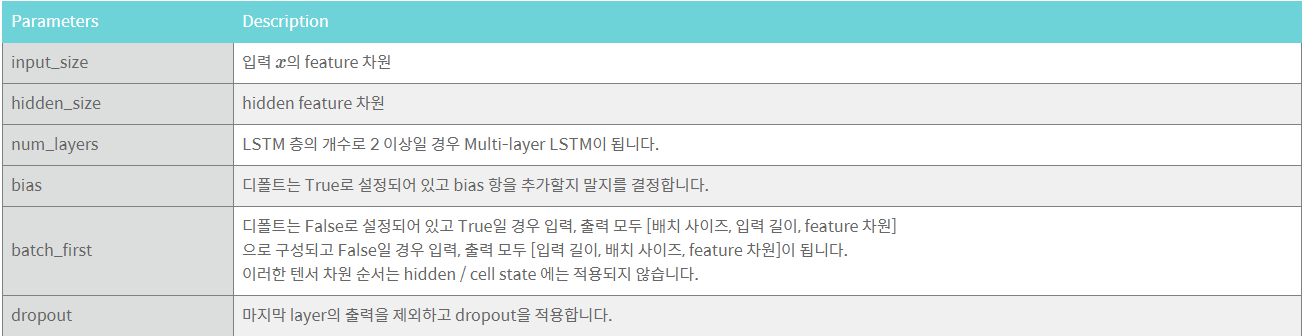

In [40]:
from torch.autograd import Variable
import torch.nn.functional as F
import os

In [41]:
class BasicLSTM(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes):
        super(BasicLSTM, self).__init__()
        print("Building Basic LSTM model...")

        
        self.n_layers = n_layers 
        #n_vocab : Vocab 안에 있는 단어의 개수, embed_dim : 임베딩 된 단어 텐서가 갖는 차원 값(dimension)
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.hidden_dim = hidden_dim
#---------------------------------------------- 여기 밑부터 작성해주세요~-------------------------------------------------
        #앞에서 정의한 하이퍼 파라미터를 넣어 LSTM 정의
        self.lstm = nn.LSTM(input_size=embed_dim, 
                            hidden_size=self.hidden_dim, 
                            num_layers=self.n_layers,
                            batch_first=True)
        
        #Input: LSTM의 hidden state vector(context), Output : Class probability vector
        self.out = nn.Linear(self.hidden_dim, n_classes)
#----------------------------------------------여기까지-------------------------------------------------

    def forward(self, x):
        # Input data: 한 batch 내 모든 영화 평가 데이터
        
        x = self.embed(x)# 영화 평 임베딩

        # 초기 hidden, cell state vector를 zero vector로 생성
        h_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim)).to(DEVICE)
        c_0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim)).to(DEVICE)
#------------------------------------------------여기 밑부터 작성해주세요-------------------------------------------------------------
        output, (h_t, c_t) = self.lstm(x, (h_0, c_0)) 
        #print(h_t.shape)
        #(1,64,h) ==> 64 batch-size,  h hidden_dimmension

        # 영화 리뷰 배열들을 압축한 hidden state vector
        # (batch_size, hidden_dim)형태의 텐서 추출
        h_t = h_t.view(-1, self.hidden_dim)

#-------------------------------------------------여기까지---------------------------------------------------------
        # linear layer의 입력으로 주고, 각 클래스 별 결과 logit을 생성.
        logit = self.out(h_t)  # [b, h] -> [b, o]
        return logit

In [42]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        optimizer.zero_grad()# 매번 기울기를 새로 계산하기 위해서 zero 로 초기화
        logit = model(x)#모델의 예측값 logit 계산
        #print(y)
        loss = F.cross_entropy(logit, y)# logit과 실제 label간의 오차를 구하고 기울기 계산
        loss.backward()
        optimizer.step()

In [43]:
def evaluate(model, val_iter):
    """evaluate model"""                   
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:# Validation 데이터셋에 대하여 
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    # 전체 validation 셋에 대한 평균 loss와 accuracy를 구하는 과정
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

참고 : __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes):

In [44]:
model = BasicLSTM(1, 32, vocab_size, 128, n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Building Basic LSTM model...


In [45]:
model

BasicLSTM(
  (embed): Embedding(30547, 128)
  (lstm): LSTM(128, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [50]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[이폭: %d] 검증 오차:%5.2f | 검증 정확도:%5.2f" % (e, val_loss, val_accuracy))
    
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

[이폭: 1] 검증 오차: 0.62 | 검증 정확도:68.39
[이폭: 2] 검증 오차: 0.67 | 검증 정확도:67.77
[이폭: 3] 검증 오차: 0.80 | 검증 정확도:67.92
[이폭: 4] 검증 오차: 0.89 | 검증 정확도:67.46
[이폭: 5] 검증 오차: 1.08 | 검증 정확도:68.04
[이폭: 6] 검증 오차: 1.29 | 검증 정확도:67.62
[이폭: 7] 검증 오차: 1.43 | 검증 정확도:67.17
[이폭: 8] 검증 오차: 1.58 | 검증 정확도:67.33
[이폭: 9] 검증 오차: 1.71 | 검증 정확도:67.09
[이폭: 10] 검증 오차: 1.88 | 검증 정확도:66.71


In [51]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))

테스트 오차:  0.61 | 테스트 정확도: 68.88
